A Jupyter notebook for week 1 of advanced python.

*Author: Jiayi Zhang* (jz6521@princeton.edu)

In [273]:
# import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [274]:
# load meta data
meta_fp = "data/metadata.csv" # meta data filepath
df = pd.read_csv(meta_fp, index_col=0)

In [275]:
df

,study,mouse_id,n_left_trials,n_right_trials,data_path
0,Daie et al. 2021,0,86,108,data/recording_0.npy


In [276]:
# mouse id we want to investigate
idx = 0
data_path = df[df["mouse_id"] == idx]["data_path"].item()

# load actual data
data = np.load(data_path, allow_pickle=True)
data = data.item()


In [277]:
# inspect the elements that are stored in data (dictionary method)
data.keys()

dict_keys(['L', 'R', 'correct_L_trials', 'correct_R_trials', 'go_cue', 'stim'])

In [278]:
# what's in data?
print(data["L"].shape)
n_time_steps, n_neurons, n_left_trials = data["L"].shape
n_left_trials_record = df[df["mouse_id"] == idx]["n_left_trials"].item()

# assert that we have the correct dimensions
assert(n_left_trials == n_left_trials_record)
print("The dataset contains the correct number of left trials")

n_right_trials = data["R"].shape[-1]
n_trials = n_left_trials + n_right_trials

(157, 274, 86)
The dataset contains the correct number of left trials


In [279]:
# how about timing information
go_cue = data["go_cue"]
print("go cue happens at time step ", go_cue)
stim_on, stim_off = data["stim"]
print(f"audio stimulations starts at time step {stim_on} and ends at time step {stim_off}")

go cue happens at time step  110
audio stimulations starts at time step 7 and ends at time step 36


Plot average activity of some neurons

Text(0.02, 0.5, '$\\Delta F/F$')

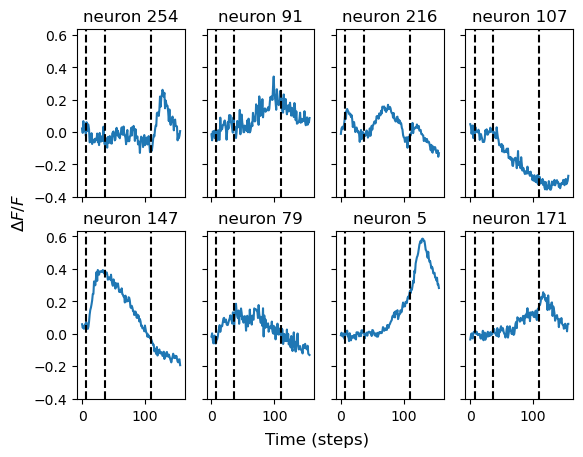

In [282]:
f, axs = plt.subplots(2, 4, sharex=True, sharey=True)
axs = axs.flatten()

# what if I set a seed for randint?
seed = 0
# neuron_id = [124, 20, 49, 1, 23, 5, 2, 99]
neuron_id = np.random.randint(n_neurons, size=8)
# neuron_id.sort()

for i, idx in enumerate(neuron_id):
    # getting trial avg activity of the current neuron
    avg_activity = np.mean(data["L"][:,idx,:], axis=1)
    axs[i].plot(avg_activity)
    axs[i].set_title(f"neuron {idx}")

    # plot the trial timings
    for timing in [go_cue, stim_on, stim_off]:
        # check out how you can plot these lines and change their styles
        axs[i].axvline(x=timing, ls="--", c="k")

f.supxlabel("Time (steps)")
f.supylabel(r"$\Delta F/F$")

## How to predict the animal's choice based on the neural activities?
Try a linear regressor/decoder! （20min)

What we know (x) are the activities of the mouse ALM neurons during task. What we want to predict (y) is the animal's choice at the end of the trial.

In [283]:
# Naively, we can use neural activity and animal choice from all trials. 
activity = np.concatenate([data["L"], data["R"]], axis=-1)
# rearrange activity such that the axis are: time x trials x neurons
activity = np.transpose(activity, axes=[0, 2, 1])

# let 1 denote left and 0 denote right
# convert the trial outcomes into choice 
# (~ means negation, turns True into False)
behavior = np.concatenate([data["correct_L_trials"], ~data["correct_R_trials"]])


Decoder/Multiple linear regression models follows the form:
$\hat{\textbf{y}} = f(\textbf{x}) = \sum_i^n a_i \times x_i + b ~(+ \epsilon)$. Note the vectors are bold-faced, i.e. $\textbf{x} = (x_0, x_1, ..., x_n)$.

Here, the vector $\textbf{x}$ would be the observed neural dynamics. We must make a decision of its exact form (depending on our hypothesis and assumptions). I am interested in finding which neurons' activity help predict the animal behavior, and I assume that *ONE fixed decoder model is enough to explain choice in terms of behavior throughout the tria*l.

**What does this assumption give us? What if I assume that I need a different decoder at each time step?**

In [284]:
# this might be the most difficult block to think through
# -1 means I want np to figure out the dimensionality of the remaining axis
# it would be equivalent to n_trials x n_times
x = np.reshape(activity, (-1, n_neurons), order="F") 
y = np.reshape(np.tile(behavior, (n_time_steps, 1)), (1, -1), order="F")
y = np.squeeze(y)

# If you are confused, you can try to print out the dimensionality of the matrices above.
# Look up what reshape, squeeze and tile do from numpy doc

In [285]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [286]:
rep = 10 # do a 10 way cross validation
train_ratio = 0.3

# store trained decoder
models = []
scores = {"train":[], "test":[]}

for r in range(rep):
    # split train, test data
    x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                        train_size=train_ratio)
    # train decoder
    decoder = LinearRegression() # create an instance
    decoder.fit(x_train, y_train) # fit to training data

    # evaluate on train and test data
    r2_train = decoder.score(x_train, y_train)
    r2_test = decoder.score(x_test, y_test)

    models.append(decoder)
    scores["train"].append(r2_train)
    scores["test"].append(r2_test)



Text(0, 0.5, '$R^2$ (model performance)')

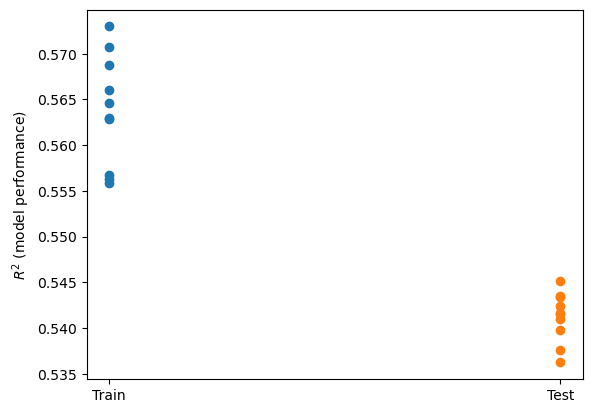

In [287]:
plt.scatter(np.ones_like(scores["train"]), scores["train"])
plt.scatter(np.ones_like(scores["test"])*2, scores["test"])
plt.xticks([1, 2], ["Train", "Test"])
plt.ylabel(r"$R^2$ (model performance)")

At this point, you might frown: hey this is pretty bad performance isn't it? However, we need to take a step back and think: what is the expected value of the performance given our metric? Is this unreasonable for us to proceed?

In [288]:
# now at every time point, see what's the prediction by this decoder
decoder_id = np.argmax(scores["test"])
best_model = models[decoder_id]
pred = best_model.predict(x)
pred = np.reshape(pred, (n_time_steps, n_trials), order="F")

Text(0, 0.5, 'Decision')

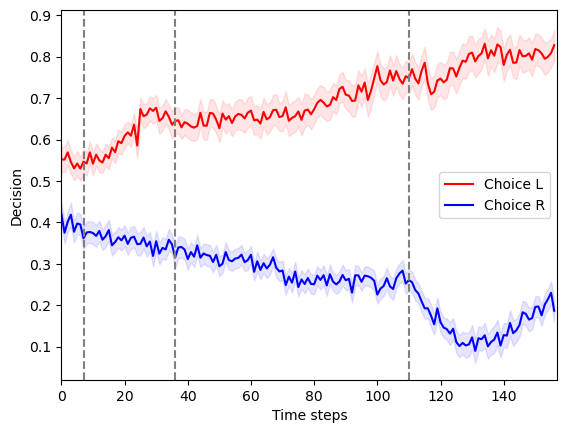

In [289]:
colors = {"L": "red", "R": "blue"}

# get average predictions across all left and right trials
avg_L = np.mean(pred[:, :n_left_trials], axis=1)
avg_R = np.mean(pred[:, n_left_trials:], axis=1)

# get standard error of predictions
se_L = np.std(pred[:, :n_left_trials], axis=1) / np.sqrt(n_left_trials)
se_R = np.std(pred[:, n_left_trials:], axis=1) / np.sqrt(n_right_trials)

# visualize predictions and results!
plt.plot(avg_L, c=colors["L"], label="Choice L")
plt.fill_between(range(n_time_steps), avg_L-se_L, avg_L+se_L, 
                 color=colors["L"], alpha=0.1)
plt.plot(avg_R, c=colors["R"], label="Choice R")
plt.fill_between(range(n_time_steps), avg_R-se_R, avg_R+se_R, 
                 color=colors["R"], alpha=0.1)

# plot timing information!
for t in [go_cue, stim_on, stim_off]:
    plt.axvline(x=t, color="gray", ls="--")

plt.xlim([0, n_time_steps])
plt.legend()

plt.xlabel("Time steps")
plt.ylabel("Decision")

In [290]:
coeffs = best_model.coef_
# plt.plot(coeffs, "o")
print("most pos weight/coeff belongs to neuron: ", np.argmax(coeffs))
print("most neg weight/coeff belongs to neuron: ", np.argmin(coeffs))

most pos weight/coeff belongs to neuron:  19
most neg weight/coeff belongs to neuron:  14


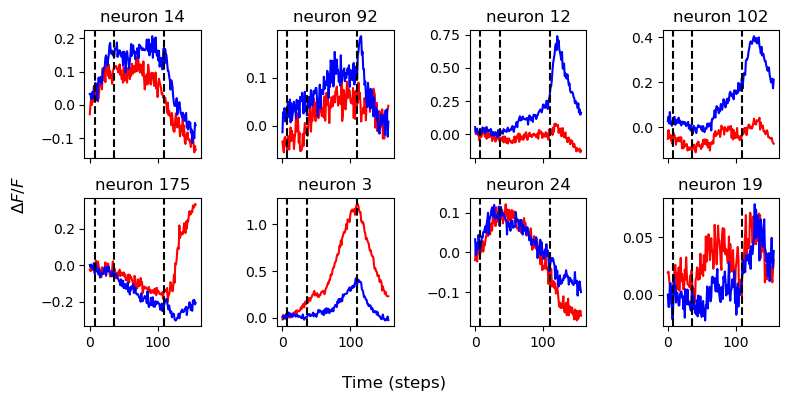

In [291]:
f, axs = plt.subplots(2, 4, figsize=(8, 4), sharex=True)
axs = axs.flatten()

coeff_order = np.argsort(coeffs)
neuron_id = np.concatenate([coeff_order[:4],coeff_order[-4:]])

for i, idx in enumerate(neuron_id):
    # getting trial avg activity of the current neuron
    avg_activity_L = np.mean(data["L"][:,idx,:], axis=1)
    avg_activity_R = np.mean(data["R"][:,idx,:], axis=1)
    axs[i].plot(avg_activity_L, c=colors["L"])
    axs[i].plot(avg_activity_R, c=colors["R"])
    axs[i].set_title(f"neuron {idx}")

    # plot the trial timings
    for timing in [go_cue, stim_on, stim_off]:
        # check out how you can plot these lines and change their styles
        axs[i].axvline(x=timing, ls="--", c="k")

f.supxlabel("Time (steps)")
f.supylabel(r"$\Delta F/F$")
plt.tight_layout()